In [1]:
import sys
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource, LogNorm
import numpy as np
import sys 
import os
import h5py
from torreylabtools import helpers
from astropy import constants as cons
from astropy import units as u
import matplotlib as mpl
from LtU_get_property_notebook import get_particle_property_LTU
import arepo_package_notebook as arepo_package
from load_temps import *
from scipy.stats import iqr
%matplotlib inline

In [2]:
os.environ["MANPATH"] = "/standard/torrey-group/Share/texlive/2018/texmf-dist/doc/man:" + os.environ.get("MANPATH", "")
os.environ["INFOPATH"] = "/standard/torrey-group/Share/texlive/2018/texmf-dist/doc/info:" + os.environ.get("INFOPATH", "")
os.environ["PATH"] = "/standard/torrey-group/Share/texlive/2018/bin/x86_64-linux:/standard/torrey-group/Share/texlive/2018/texmf-dist:" + os.environ.get("PATH", "")

In [3]:
data_path = 'output/Temps/'
files = ['Constrained_gas_BH_properties.hdf5','Low_mass_seeds_gas_BH_properties.hdf5','Zooms_gas_BH_properties.hdf5']

redshifts = np.arange(6, 17)

h5file = data_path + files[0]
with h5py.File(h5file, 'r') as f:
    keys_C = list(f.keys())
    
h5file = data_path + files[1]
with h5py.File(h5file, 'r') as f:
    keys_L = list(f.keys())
    
h5file = data_path + files[2]
with h5py.File(h5file, 'r') as f:
    keys_Z = list(f.keys())

In [4]:
data_path = 'output/Temps/'
files = ['Constrained_gas_BH_properties.hdf5','Low_mass_seeds_gas_BH_properties.hdf5','Zooms_gas_BH_properties.hdf5']

h5file = data_path + files[0]
sim = 'Bondi_constrained_AGN_fewseeds_0.1stellar'
redshift = 6
B_C_AGN_low_z6= load_box_data_dict(h5file, sim, redshift, include_attrs=True)
B_C_AGN_low_z6.keys()

dict_keys(['bh_coords', 'gas_coords', 'gas_masses', 'gas_sfr_in_hsml', 'gas_temps', 'attrs'])

In [5]:
B_C_AGN_low_z6['attrs']['bh_mass']

np.float32(31580674.0)

In [6]:
data_path = 'output/Temps/'
files = {
    'C': 'Constrained_gas_BH_properties.hdf5',
    'Z': 'Zooms_gas_BH_properties.hdf5',
    'L': 'Low_mass_seeds_gas_BH_properties.hdf5',
}

keys = {
    'C': keys_C,
    'Z': keys_Z,
    'L': keys_L,
}

f = 4

Mean_temps   = {}
G1_IQR       = {}
Star_forming = {}
N_cells      = {}

for tag in ['C', 'Z', 'L']:

    h5file = data_path + files[tag]

    Mean_temps[tag]   = []
    G1_IQR[tag]       = []
    Star_forming[tag] = []
    N_cells[tag]      = []

    for key in keys[tag]:

        Sim_temps  = []
        Sim_IQR    = []
        Sim_SFR    = []
        Sim_cells  = []

        for z in redshifts:

            box_temp  = load_box_data(h5file, key, z, 'gas_temps')
            mean_temp = np.mean(box_temp)
            IQR       = iqr(box_temp)
            n         = np.sum(box_temp > mean_temp + f * IQR)

            box_sfrs     = load_box_data(h5file, key, z, 'gas_sfr_in_hsml')
            star_forming = np.sum(box_sfrs != 0)

            Sim_temps.append(mean_temp)
            Sim_IQR.append(n)
            Sim_SFR.append(star_forming)
            Sim_cells.append(len(box_sfrs))

        Mean_temps[tag].append(Sim_temps)
        G1_IQR[tag].append(Sim_IQR)
        Star_forming[tag].append(Sim_SFR)
        N_cells[tag].append(Sim_cells)

    # Convert once per box
    Mean_temps[tag]   = np.log10(np.array(Mean_temps[tag]))
    G1_IQR[tag]       = np.array(G1_IQR[tag])
    Star_forming[tag] = np.array(Star_forming[tag])
    N_cells[tag]      = np.array(N_cells[tag])

# Final named outputs (drop-in compatible)
Mean_temps_C = Mean_temps['C']
Mean_temps_Z = Mean_temps['Z']
Mean_temps_L = Mean_temps['L']


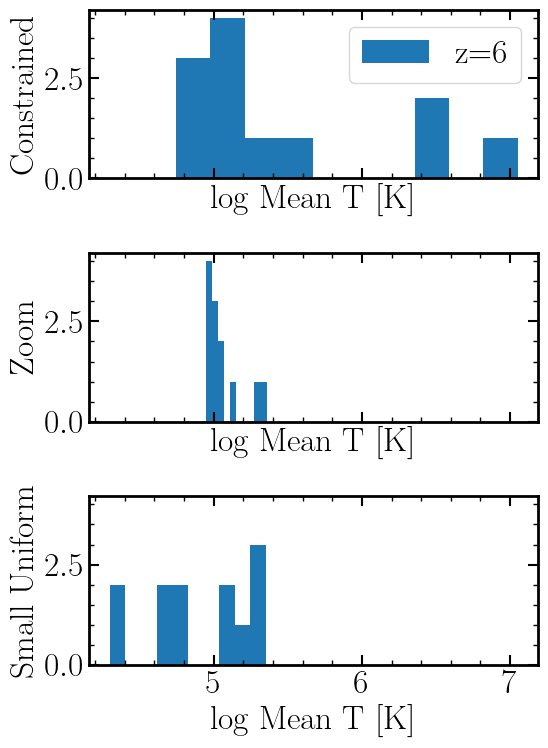

In [7]:
i = 0
fig,axs = plt.subplots(3,1,figsize=(6,8),sharey=True,sharex=True)

axs[0].hist(Mean_temps_C[:,i],label = f'z={redshifts[i]}')
axs[0].set_ylabel('Constrained')
axs[0].set_xlabel('log Mean T [K]')
axs[0].legend()

axs[1].hist(Mean_temps_Z[:,i],label = f'z={redshifts[i]}')
axs[1].set_ylabel('Zoom')
axs[1].set_xlabel('log Mean T [K]')

axs[2].hist(Mean_temps_L[:,i],label = f'z={redshifts[i]}')
axs[2].set_ylabel('Small Uniform')
axs[2].set_xlabel('log Mean T [K]')

fig.tight_layout()
fig.show()

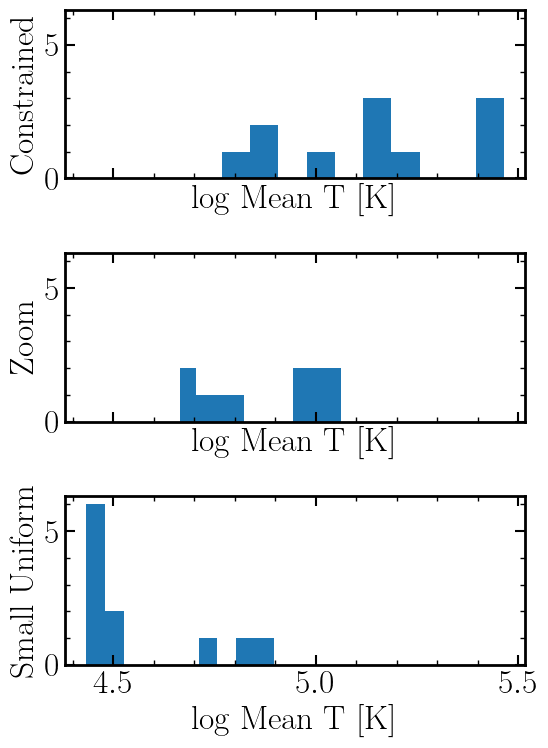

In [8]:
mean_of_means_C = np.mean(Mean_temps_C,axis=0)
mean_of_means_Z = np.mean(Mean_temps_Z,axis=0)
mean_of_means_L = np.mean(Mean_temps_L,axis=0)

fig,axs = plt.subplots(3,1,figsize=(6,8),sharey=True,sharex=True)

axs[0].hist(mean_of_means_C,label = f'z={redshifts[i]}')
axs[0].set_ylabel('Constrained')
axs[0].set_xlabel('log Mean T [K]')

axs[1].hist(mean_of_means_Z,label = f'z={redshifts[i]}')
axs[1].set_ylabel('Zoom')
axs[1].set_xlabel('log Mean T [K]')

axs[2].hist(mean_of_means_L,label = f'z={redshifts[i]}')
axs[2].set_ylabel('Small Uniform')
axs[2].set_xlabel('log Mean T [K]')

fig.tight_layout()
fig.savefig('Plots/Temps/Mean_temps.png')

# Number of cells 1 IQR above the mean vs mean temp plot

In [ ]:
data_path = 'output/Temps/'
files = ['Constrained_gas_BH_properties.hdf5','Low_mass_seeds_gas_BH_properties.hdf5','Zooms_gas_BH_properties.hdf5']

h5file = data_path + files[0]
key = keys_C[1]
z=redshifts[1]
box_temp = load_box_data(h5file, key, z, 'gas_temps')

In [ ]:
len(box_temp)

In [ ]:
plt.hist(np.log10(box_temp))
plt.show()

In [ ]:
plt.scatter(Mean_temps_C,G1_IQR_C,color='blue',label='Constrained') 
plt.scatter(Mean_temps_Z,G1_IQR_Z,color='orange',label = 'Zooms') 
plt.scatter(Mean_temps_L,G1_IQR_L,color='green',label = 'Small Uniform') 
plt.xlabel('log Mean Temp [K]')
plt.ylabel(f'N outliers, f = {f}') # Outliers: f * IQR above mean temp
plt.yscale('log')
plt.legend(fontsize=15,loc=4)

plt.tight_layout()
plt.savefig(f'Plots/Temps/N_T_f{f}.png')

In [ ]:
plt.scatter(Mean_temps_C,G1_IQR_C,color='blue',label='Constrained') 
plt.scatter(Mean_temps_Z,G1_IQR_Z,color='orange',label = 'Zooms') 
plt.scatter(Mean_temps_L,G1_IQR_L,color='green',label = 'Small Uniform') 
plt.xlabel('log Mean Temp [K]')
plt.ylabel(f'N outliers, f = {f}') # Outliers: f * IQR above mean temp
plt.yscale('log')
plt.legend(fontsize=15,loc=4)

plt.tight_layout()
plt.savefig(f'Plots/Temps/N_T_f{f}.png')

## Now: want to split the above plot by IC and  color code based on feedback

In [ ]:
sim = 'Constrained'

plt.scatter(Mean_temps_C,G1_IQR_C,color='blue',label=f'{sim}') 
plt.xlabel('log Mean Temp [K]')
plt.ylabel(f'N outliers, f = {f}') # Outliers: f * IQR above mean temp
plt.yscale('log')
plt.legend(fontsize=15,loc=4)

plt.tight_layout()
plt.savefig(f'Plots/Temps/N_T_f{f}_{sim}.png')

# Want to load in the SFRs of the gas cells to see if a highly star forming gas cell could be causing the high temps via the EOS

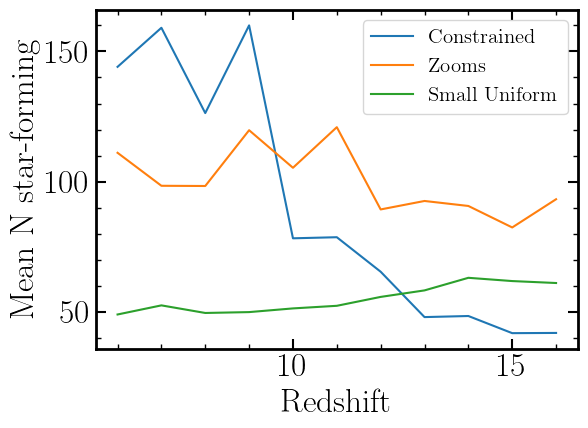

In [10]:
plt.plot(redshifts,np.mean(N_cells['C'],axis=0),label = 'Constrained')
plt.plot(redshifts,np.mean(N_cells['Z'],axis=0),label = 'Zooms')
plt.plot(redshifts,np.mean(N_cells['L'],axis=0),label = 'Small Uniform')
plt.legend(fontsize=15)
plt.xlabel('Redshift')
plt.ylabel('Mean N star-forming')
plt.tight_layout()
# plt.yscale('log')
plt.savefig('Plots/Temps/N_SFR.png')